# Wine Quality Classification
## Introduction
The aim of this analysis is to develop a classification model, used to classify wine taste. The dataset is a subset of the widely known UCI Machine Learning Repository's Wine Quality dataset. The classification labels have been trimmed from multinomial to binomial.<br />

It is highly recommended that you familirise yourself with this dataset prior to continuing below. In the interest of keeping the document length low and just all around repetition of information we assume that you know much of the dataset specific information from the UCIMLR page. You can find more about the UCIMLR's wine quality dataset at https://archive.ics.uci.edu/ml/datasets/Wine+Quality 

In this analysis, focus is on **Logistic Regression.** If you are unfamiliar with Logistic Regression, find out more at https://en.wikipedia.org/wiki/Logistic_regression.

To control our model complexity and performance, we will apply some crossvalidation and regularisation methods. We will stick to just **k-fold crossvalidation** although we will apply both **L1** and **L2** regularisation to see how each behaves.<br />
In addition to this, we will apply a forward search stepwise variable selection to simplify our model as much as possible.<br />

## Fixes from Assignment 1 Feedback.
1. Added **Introduction** section to give a brief overview of analysis and dataset. Attached links to get more information.
2. Enhanced figure discriptions to capture audiences with non statistical backgrounds. Embedded links to helper articles.
3. Correlation plot now has values attached so user does not need to intepret using colour bar.
4. Histograms - Extra aesthetic colouring has been removed. Colour now corresponds to additional information. Added comments in markdown explaining colours.
5. Boxplots - Extra aesthetic colouring has been removed. Colour now corresponds to additonal information. Added commetns in markdown explaining colours.
6. Engineered features have more descriptive explanations. 
7. EDA Summary has been added.


## Libraries & Helper Functions
A host of helper functions are used in this analysis to reduce the amount of repatitive code or just plain annoying code to write. They are all loaded below. See individual helpers for their descriptions.

There is also a number of libraries that are required in this analysis. They vary from visualisation aids to modelling and training tools. 

In [24]:
## REQUIRED PACKAGES ##
#######################
require(ggplot2)
require(corrplot)
require(caret)
require(glmnet)

## HELPER FUNCTIONS ##
######################
udf_utils_MultiPlot <- function(..., plotlist = NULL, file, cols = 1, layout = NULL) {
    
    
    #####################################################
    # Multiplot for ggplot2                             
    # REFERENCE: http://www.cookbook-r.com/Graphs/Multiple_graphs_on_one_page_(ggplot2)/            
    #####################################################
    
    
    # Multiple plot function
    #
    # ggplot objects can be passed in ..., or to plotlist (as a list of ggplot objects)
    # - cols:   Number of columns in layout
    # - layout: A matrix specifying the layout. If present, 'cols' is ignored.
    #
    # If the layout is something like matrix(c(1,2,3,3), nrow=2, byrow=TRUE),
    # then plot 1 will go in the upper left, 2 will go in the upper right, and
    # 3 will go all the way across the bottom.
    library(grid)
    
    # Make a list from the ... arguments and plotlist
    plots <- c(list(...), plotlist)
    
    numPlots = length(plots)
    
    # If layout is NULL, then use 'cols' to determine layout
    if (is.null(layout)) {
        # Make the panel
        # ncol: Number of columns of plots
        # nrow: Number of rows needed, calculated from # of cols
        layout <- matrix(seq(1, cols * ceiling(numPlots / cols)),
                         ncol = cols, nrow = ceiling(numPlots / cols))
    }
    
    if (numPlots == 1) {
        print(plots[[1]])
        
    } else {
        # Set up the page
        grid.newpage()
        pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))
        
        # Make each plot, in the correct location
        for (i in 1:numPlots) {
            # Get the i,j matrix positions of the regions that contain this subplot
            matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))
            
            print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                            layout.pos.col = matchidx$col))
        }
    }
}
udf_eda_MultBoxPlot <- function(numericDataFrame,ncol=11) {

    ## Description : This function plots ggplot boxplots with free scales for a numeric dataframe. 
    # Input : A dataframe with numeric values.
    # Output : ggplot2 object.

    require(reshape2)
    require(ggplot2)
    tmp__ <- numericDataFrame

    tmp__[, "idx"] <- row.names(tmp__)
    tmp__ <- melt(tmp__, id.vars = "idx")

    p_ <- ggplot(data = tmp__,aes(factor(1),value)) + geom_boxplot() + facet_wrap(~ variable,scales = "free",ncol = ncol) + theme(axis.text.x=element_blank(),axis.title.x=element_blank(),axis.title.y=element_blank())

    return(p_)
}


udf_eda_FeatTargetHist <- function(data=dt_,featName="fixed.acidity",targetName="quality",alpha = 0.5){
    require(ggplot2)
    
    camelize <- function(x) {
        
        x <- gsub("\\."," ",x)
        s <- strsplit(x, " ")[[1]]
        paste(toupper(substring(s, 1,1)), substring(s, 2),
              sep="", collapse=" ")
    }
    
    tmp__ <- data[,c(featName,targetName)]
    
    plt_ <- ggplot(tmp__,aes(tmp__[,featName])) + geom_density(aes(fill = tmp__[,targetName]),alpha = alpha) + scale_fill_brewer(palette = "Set1", name = camelize(targetName)) + scale_x_continuous(name = camelize(featName)) + scale_y_continuous(name = "Observation Density") + ggtitle(paste0("Distribution of ",camelize(featName)," On ",camelize(targetName)))
    
    return(plt_)
}

udf_eda_FeatTargetBox <- function(data=dt_,featName="fixed.acidity",targetName="quality",alpha = 1){
    require(ggplot2)
    
    camelize <- function(x) {
        
        x <- gsub("\\."," ",x)
        s <- strsplit(x, " ")[[1]]
        paste(toupper(substring(s, 1,1)), substring(s, 2),
              sep="", collapse=" ")
    }
    
    tmp__ <- data[,c(featName,targetName)]
    
    plt_ <- ggplot(tmp__,aes(tmp__[,targetName],tmp__[,featName])) + geom_boxplot(aes(fill = tmp__[,targetName]),alpha = alpha) + scale_x_discrete(name = camelize(targetName)) + scale_y_continuous(name = camelize(featName)) + scale_fill_brewer(palette = "Set1",name = camelize(targetName)) + ggtitle(paste0("Histogram of ",camelize(featName)," by ",camelize(targetName))) + coord_flip()
    
    return(plt_)
}

udf_eda_CorrTargetScatter <- function(data=dt_,xData="fixed.acidity",yData="pH",targetName="quality",smooth=TRUE){
    
    require(ggplot2)
    
    camelize <- function(x) {
        
        x <- gsub("\\."," ",x)
        s <- strsplit(x, " ")[[1]]
        paste(toupper(substring(s, 1,1)), substring(s, 2),
              sep="", collapse=" ")
    }
    
    tmp__ <- data[,c(xData,yData,targetName)]
    
    plt_ <- ggplot(tmp__,aes(tmp__[,xData],tmp__[,yData],colour = tmp__[,targetName])) + geom_point(shape = 16,size =2 , alpha = 0.5) + scale_color_brewer(palette = "Set1",name = camelize(targetName)) + scale_x_continuous(name = camelize(xData)) + scale_y_continuous(name = camelize(yData)) + ggtitle(paste0(camelize(xData)," ~ ",camelize(yData)," by ",camelize(targetName)))
    
    if(smooth){
        return(plt_ + geom_smooth(method="lm",se=FALSE))
    }
    else{
        return(plt_)
    }
}

Loading required package: glmnet
Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-5



## Exploratory Data Analsis
Let's explore the data set.

In [2]:
## Load the data set.
dt_ <- read.csv("Wine_training.csv")
str(dt_)

'data.frame':	3283 obs. of  12 variables:
 $ fixed.acidity       : num  7 6.3 7.2 8.1 6.2 8.1 7.9 6.6 8.3 6.6 ...
 $ volatile.acidity    : num  0.27 0.3 0.23 0.28 0.32 0.27 0.18 0.16 0.42 0.17 ...
 $ citric.acid         : num  0.36 0.34 0.32 0.4 0.16 0.41 0.37 0.4 0.62 0.38 ...
 $ residual.sugar      : num  20.7 1.6 8.5 6.9 7 ...
 $ chlorides           : num  0.045 0.049 0.058 0.05 0.045 0.033 0.04 0.044 0.04 0.032 ...
 $ free.sulfur.dioxide : num  45 14 47 30 30 11 16 48 41 28 ...
 $ total.sulfur.dioxide: num  170 132 186 97 136 63 75 143 172 112 ...
 $ density             : num  1.001 0.994 0.996 0.995 0.995 ...
 $ pH                  : num  3 3.3 3.19 3.26 3.18 2.99 3.18 3.54 2.98 3.25 ...
 $ sulphates           : num  0.45 0.49 0.4 0.44 0.47 0.56 0.63 0.52 0.67 0.55 ...
 $ alcohol             : num  8.8 9.5 9.9 10.1 9.6 12 10.8 12.4 9.7 11.4 ...
 $ quality             : Factor w/ 2 levels "bad","good": 2 2 2 2 2 1 1 2 1 2 ...


Training and testing data sets have already been separated for us. The training set seems to have **3283 observations** and **12 variables**, of which 1 is the target variable, **quality**.<br />
We can also see that all of the features (predictor variables) are numeric. They are based on physiochemical tests and include the following:<br />
1. fixed acidity (tartaric acid - g / dm^3)
2. volatile acidity (acetic acid - g / dm^3)
3. citric acid (g / dm^3)
4. residual sugar (g / dm^3)
5. chlorides (sodium chloride - g / dm^3
6. free sulfur dioxide (mg / dm^3)
7. total sulfur dioxide (mg / dm^3)
8. density (g / cm^3)
9. pH
10. sulphates (potassium sulphate - g / dm3)
11. alcohol (% by volume)<br />

The target variable **quality** has two levels, **good** or **bad**.<br />
Let's have a look at the statistical summary.

In [3]:
summary(dt_)

 fixed.acidity    volatile.acidity  citric.acid     residual.sugar  
 Min.   : 3.800   Min.   :0.0800   Min.   :0.0000   Min.   : 0.600  
 1st Qu.: 6.300   1st Qu.:0.2100   1st Qu.:0.2700   1st Qu.: 1.700  
 Median : 6.800   Median :0.2600   Median :0.3200   Median : 4.800  
 Mean   : 6.852   Mean   :0.2803   Mean   :0.3357   Mean   : 6.031  
 3rd Qu.: 7.300   3rd Qu.:0.3275   3rd Qu.:0.3900   3rd Qu.: 9.000  
 Max.   :14.200   Max.   :1.1000   Max.   :1.6600   Max.   :65.800  
   chlorides       free.sulfur.dioxide total.sulfur.dioxide    density      
 Min.   :0.00900   Min.   :  2.00      Min.   :  9.0        Min.   :0.9871  
 1st Qu.:0.03600   1st Qu.: 23.00      1st Qu.:107.0        1st Qu.:0.9917  
 Median :0.04300   Median : 33.00      Median :133.0        Median :0.9936  
 Mean   :0.04604   Mean   : 35.05      Mean   :137.7        Mean   :0.9938  
 3rd Qu.:0.05000   3rd Qu.: 45.00      3rd Qu.:166.0        3rd Qu.:0.9958  
 Max.   :0.34600   Max.   :289.00      Max.   :440.0   

We can see that there are a wide range of scale with our features. Volatile acidity has a mean of **0.28** whilst total sulfur dioxide seems to have a mean of **137.7**. Let's plot some boxplots to get a visual description of of the number outputs above.

Loading required package: reshape2


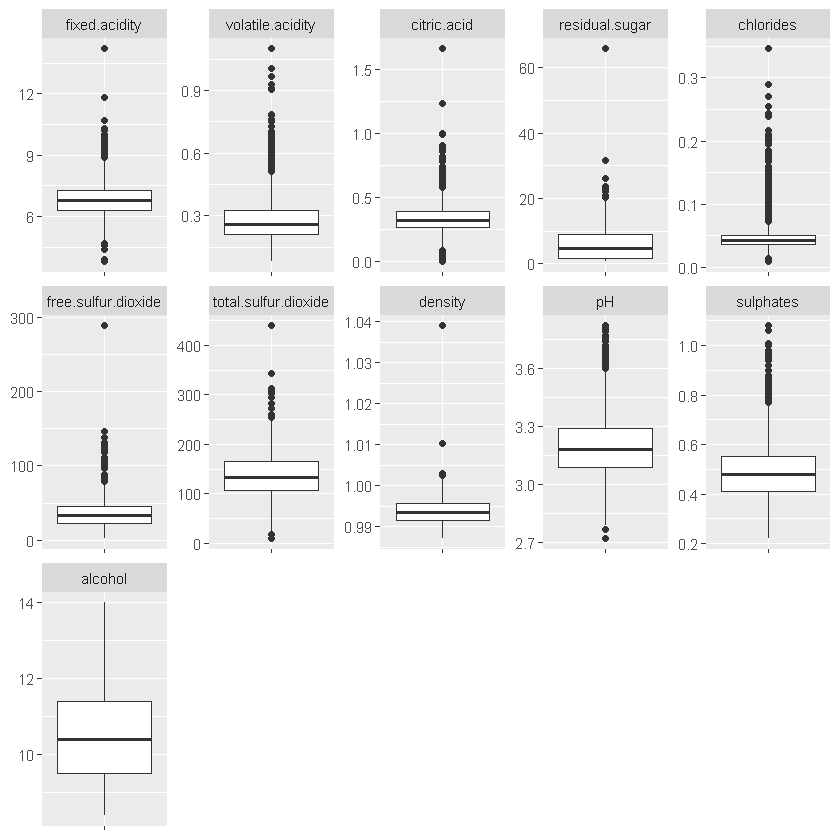

In [4]:
udf_eda_MultBoxPlot(dt_[,-ncol(dt_)],5) ## Call the helper function to plot the boxplots of the data frame. Specify 5 columns for clarity.

From the overall boxplots, we can already see that the diversity of characteristics present in the featureset. We see that many of the variables are positively skewed (volatile acidity, residual, sugar, chlorides, density, etc.) while chlorides seem to show a large numebr of outliers. It is also evident that alcohol has almost no outliers, which makes sense, we wouldnt expect to see a 50% alcohol wine. Let's have a look at each of these features in more detail.

### Univariate Data Visalisation
Below we will investigate each of the features in isolation. The main objective of univariate visualisation is to understand the distributions of each feature. We can then see whether we need to do some extreme value corrections or outlier removal tasks.
#### Quality 
Our first univariate visualisation will be quality, our target variable.

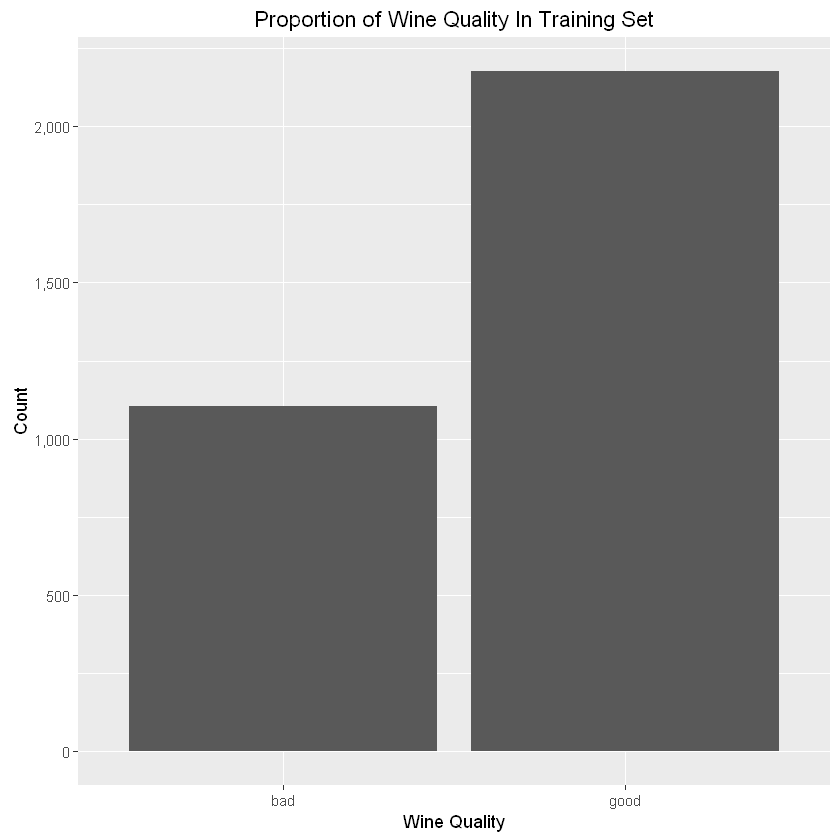

In [5]:
ggplot(dt_,aes(dt_$quality)) + geom_bar() + scale_x_discrete(name = "Wine Quality") + scale_y_continuous(name = "Count",labels = scales::comma) + ggtitle("Proportion of Wine Quality In Training Set")

We can immideately see that there is nearly twice as many wines classified as "good" as there are classified as "bad". Whether this will impact our model training significantly is hard to say.
#### Fixed Acidity
Next, let's look at fixed acidity. 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  3.800   6.300   6.800   6.852   7.300  14.200 

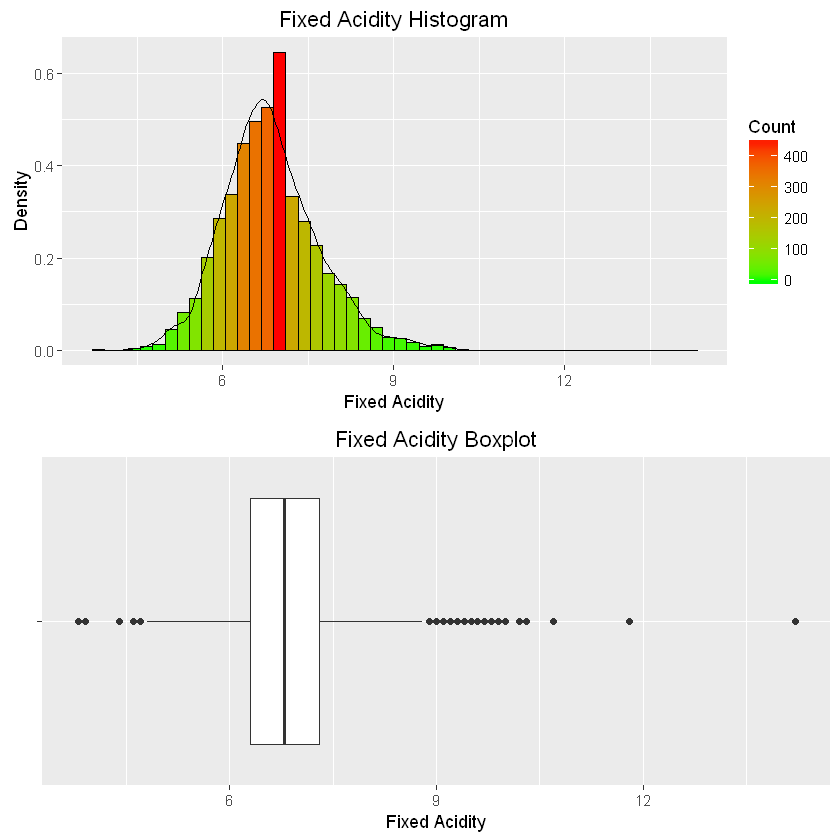

In [6]:
p1_ <- ggplot(dt_,aes(dt_$fixed.acidity)) + geom_histogram(bins = 50, colour = "black",aes(fill = ..count.., y = ..density..)) + geom_density() + scale_fill_continuous(low = "green",high = "red", name = "Count") + scale_x_continuous(name = "Fixed Acidity", labels = scales::comma) + scale_y_continuous(name = "Density") + ggtitle("Fixed Acidity Histogram")



p2_ <- ggplot(dt_,aes(as.factor(""),dt_$fixed.acidity)) + geom_boxplot() + scale_x_discrete(name = "") + scale_y_continuous(name = "Fixed Acidity") + ggtitle("Fixed Acidity Boxplot") + coord_flip()

udf_utils_MultiPlot(p1_,p2_,cols = 1)
summary(dt_$fixed.acidity)

In the above histogram, the y-scale corresponds to the density of values while the colour corresponds to the number of observed values at each bucket. It seems the data is slightly positively skewed. The distribution seems to be relatively sharp. There are a few outliers, particularly severe on the positive side. We will leave them in for now, since we don't know if this statistical outlier actually represents a real behaviour.

#### Citric Acid

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.2700  0.3200  0.3357  0.3900  1.6600 

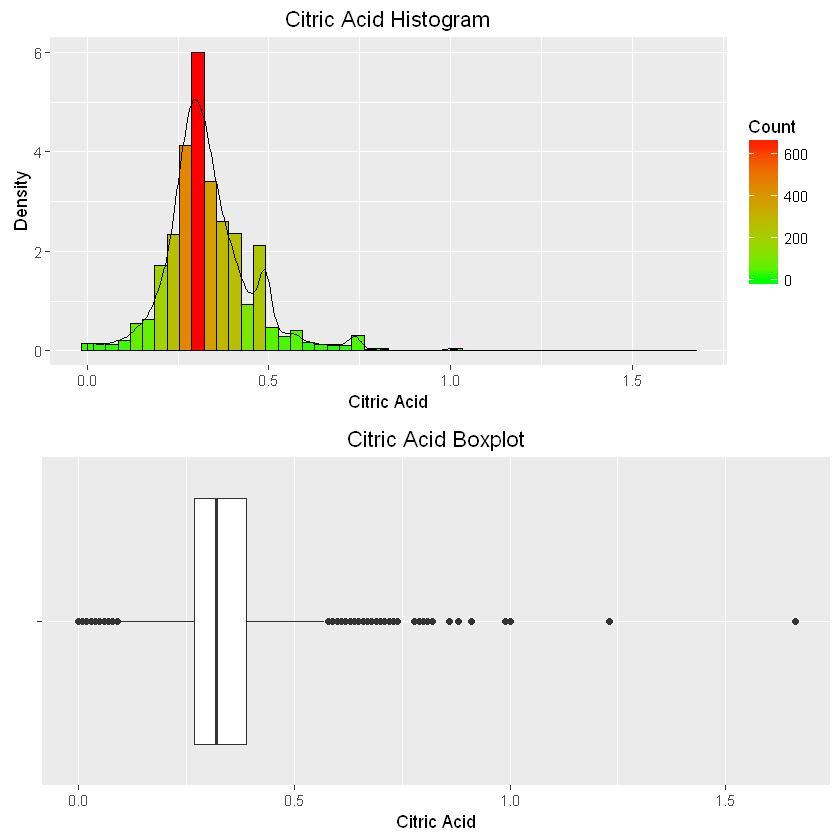

In [8]:
p1_ <- ggplot(dt_,aes(dt_$citric.acid)) + geom_histogram(bins = 50, colour = "black",aes(fill = ..count.., y = ..density..)) + geom_density() + scale_fill_gradient(low = "green",high = "red", name = "Count") + scale_x_continuous(name = "Citric Acid", labels = scales::comma) + scale_y_continuous(name = "Density") + ggtitle("Citric Acid Histogram")



p2_ <- ggplot(dt_,aes(as.factor(""),dt_$citric.acid)) + geom_boxplot() + scale_x_discrete(name = "") + scale_y_continuous(name = "Citric Acid") + ggtitle("Citric Acid Boxplot") + coord_flip()

udf_utils_MultiPlot(p1_,p2_,cols = 1)
summary(dt_$citric.acid)

It is intereseting  to see that there is spike near the **0.5 Citric Acid** concentration. Also it is extremely right skewed.  

### Principle Component Visualisation
Principle component analysis was carried out to attempt to visualise the decision boundary for classification. 

In [9]:
dt_pca <- scale(dt_[,-ncol(dt_)])
dt_pca <- prcomp(dt_pca)
summary(dt_pca)

Importance of components:
                          PC1    PC2    PC3     PC4     PC5     PC6     PC7
Standard deviation     1.7836 1.2631 1.0996 1.01666 0.99102 0.97118 0.85116
Proportion of Variance 0.2892 0.1450 0.1099 0.09396 0.08928 0.08574 0.06586
Cumulative Proportion  0.2892 0.4342 0.5441 0.63809 0.72737 0.81312 0.87898
                           PC8     PC9    PC10   PC11
Standard deviation     0.77942 0.64892 0.52766 0.1556
Proportion of Variance 0.05523 0.03828 0.02531 0.0022
Cumulative Proportion  0.93420 0.97249 0.99780 1.0000

We can see that 43.4% of the variance is explained by the first two components. 

[1] 11

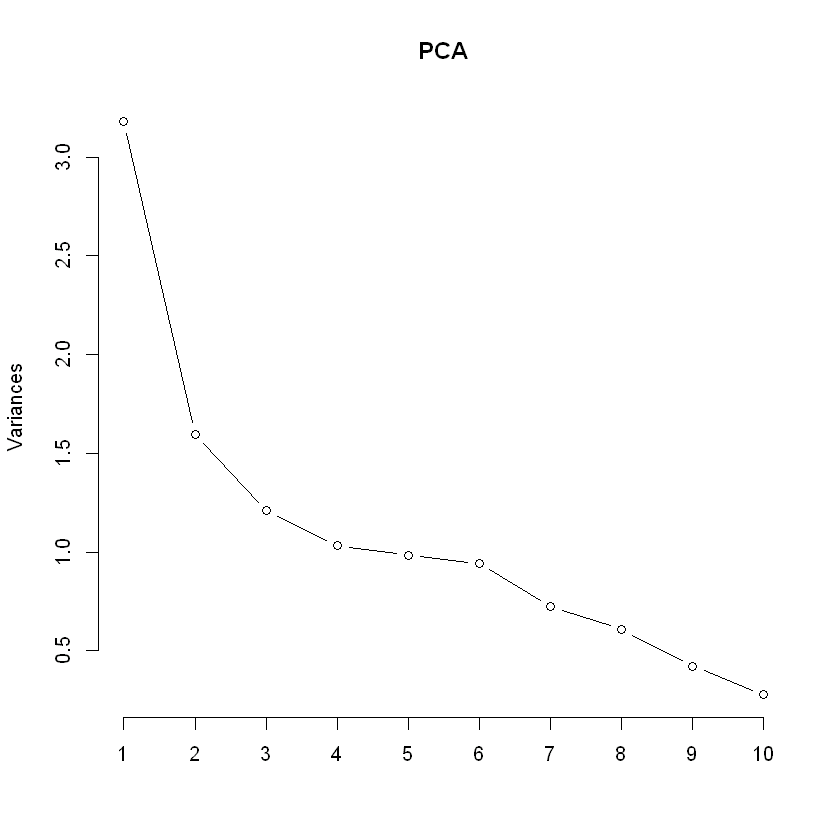

In [11]:
sum((dt_pca$sdev)^2)
plot(dt_pca,type="lines",main = "PCA")

Seems like components 3, 4, 5 and 6 have about similar weight in explaining the variance. Let's plot the classes on the prinicple components 1 and 2. 

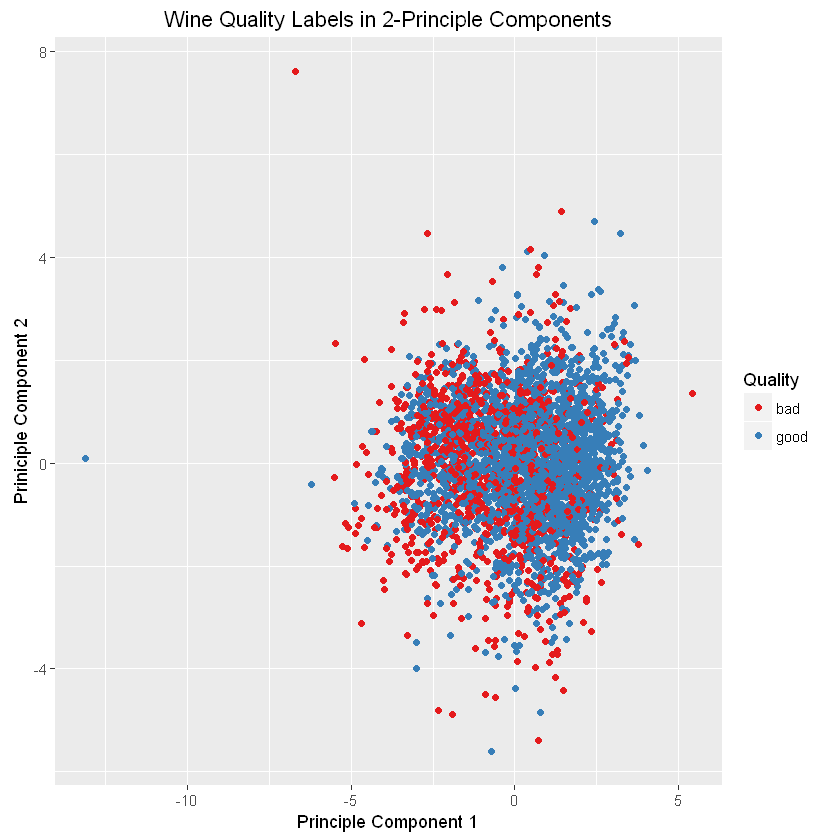

In [12]:
dt_pca <- as.data.frame(dt_pca$x[,1:4])

ggplot(dt_pca, aes(dt_pca$PC1, dt_pca$PC2)) + geom_point(aes(colour = dt_$quality)) + scale_colour_brewer(palette = "Set1", name = "Quality") + scale_y_continuous(name = "Priniciple Component 2") + scale_x_continuous(name = "Principle Component 1") + ggtitle("Wine Quality Labels in 2-Principle Components")

Looks like there is no clear decision boundary present. But we can definitely see on PC1 that left skewed values seem to be bad and right skewed values seem to be good. Let's visualise using the histogram.

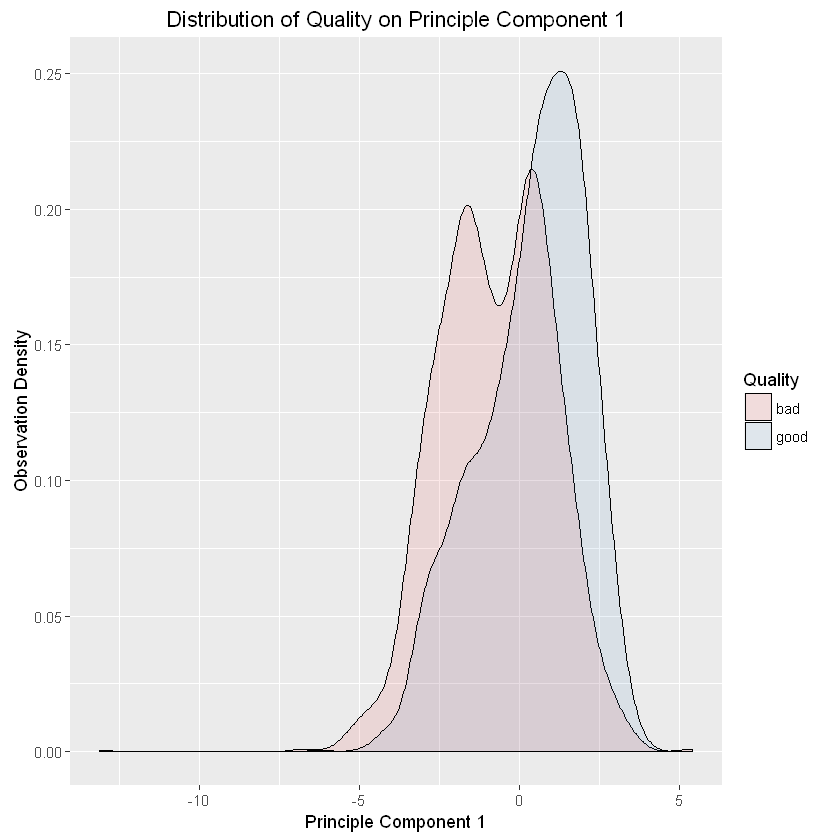

In [14]:
dt_pca <- cbind(dt_pca, dt_[, ncol(dt_)])
colnames(dt_pca)[ncol(dt_pca)] <- "Quality"


ggplot(dt_pca,aes(dt_pca$PC1)) + geom_density(aes(fill = dt_pca$Quality), alpha = 0.1) + scale_fill_brewer(palette = "Set1" , name = "Quality")  + scale_x_continuous(name = "Principle Component 1") + scale_y_continuous("Observation Density") + ggtitle("Distribution of Quality on Principle Component 1")

It is notable to see the double hump in the bad quality wines with respect to PC1. They are also both seem to be left skewed, with the good quality wines more so. 

### Bivariate Visualisations
It is important to aslo see the variable correlations. Let's see ow the overall dataset looks.

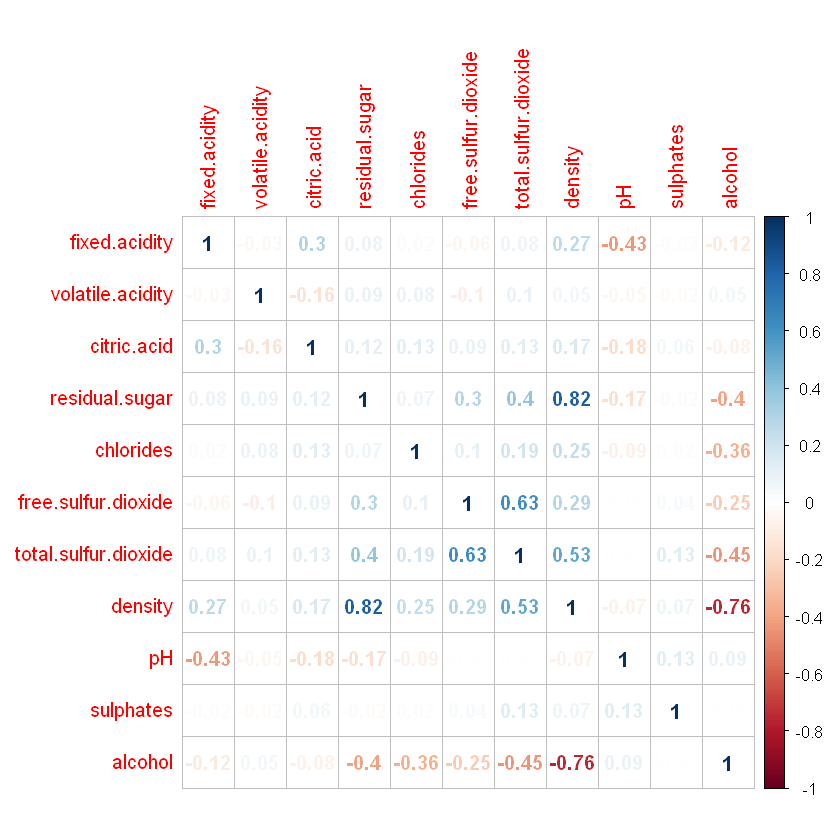

In [18]:
corrplot(cor(dt_[,-ncol(dt_)]),method = "number")

We can immideately see that some variables are inter correlated. There is a strong positive relationship with density and residual sugar. While a strong negative relationship with density and alcohol. There are a number of weak to mederate relatniships with free and total sulfur dioxide. 

#### Volatile Acidity ~ Quality

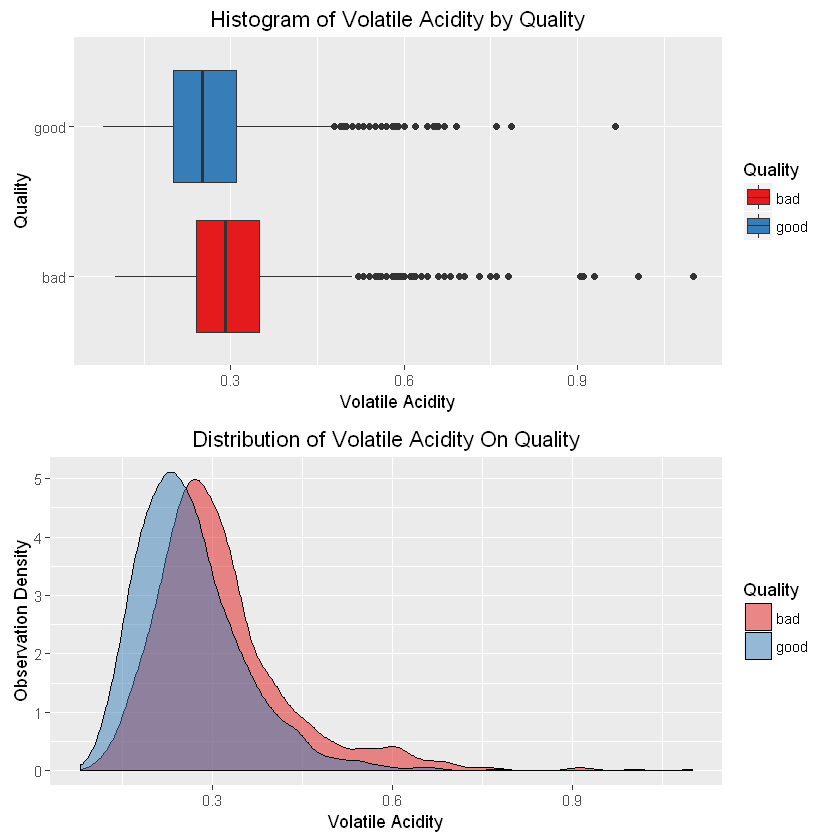

In [21]:
udf_utils_MultiPlot(udf_eda_FeatTargetBox(featName = "volatile.acidity"),udf_eda_FeatTargetHist(featName = "volatile.acidity"))

There seems to be bit of separation where the peaks occur on the good quality and bad quality wines with Volatile Acidity. In general, it seems that the good wines have lower Volatile Acidity, also shown by the large right skewness. The strength of this variable on the model may be quite high.
#### Density ~ Quality

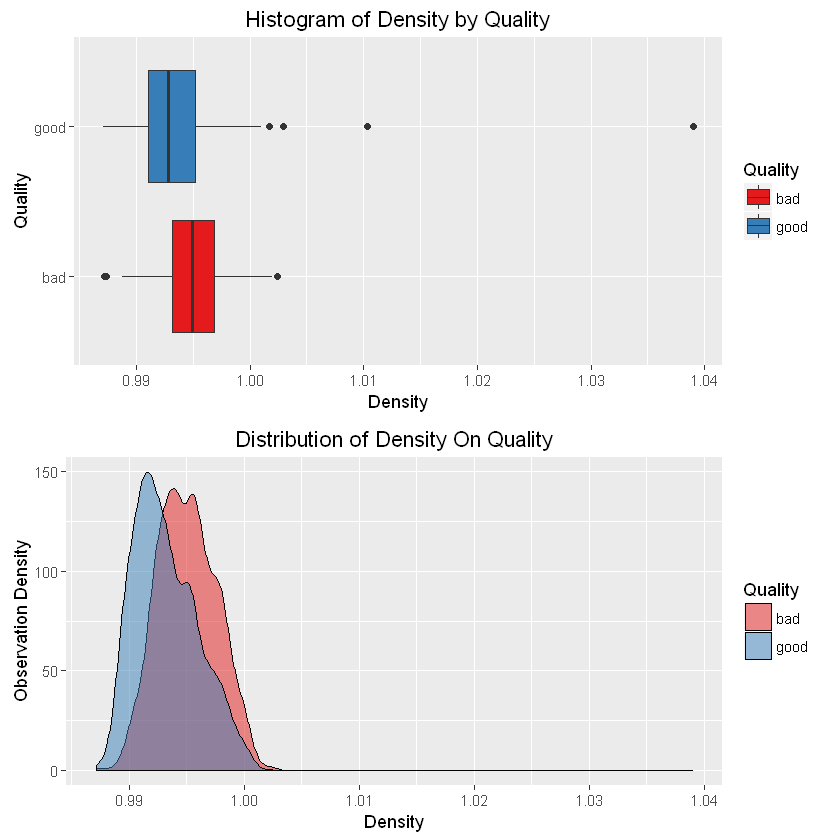

In [22]:
udf_utils_MultiPlot(udf_eda_FeatTargetBox(featName = "density"),udf_eda_FeatTargetHist(featName = "density"))

Density also seems to show a good separation of peaks in the hostigram. THere seems to be two peaks on the bad quality wines. The spread seems to be about the same with both of them being right skewed. This could potential also be a significant variable in the model that would help making the decision of good or bad wines.

## Modelling
The assessment criterea requires the evaluation of models generated in the following three methods.
1. Stepwise Selection : Use Forward Stepwise Selection method to select a single best method.
2. Ridge Regression : Model with parameters penalized with the L2 regularizer.
3. LASSO Regression : Model with parameters penalized with the L1 regularizer.

We are to also use cross validation to ensure that the parameter estimations are unaffected by set bias. We will implement 10-Fold validation here.

In [25]:
# Glmnet requires matrices of features and labels, so let's make some.
mtx_ <- as.matrix(dt_[, - ncol(dt_)])
mty_ <- as.matrix(dt_[,ncol(dt_)])

#### Stepwise Selection

First we will generate a model using stepwise selection. As required we are going to search for the significant variables using teh forward search technique. We will use the amazing caret package to manage the training process.
We will also use the **Akaike information criterion (AIC)** for the scoring of each model in the search process. This AIC has its roots in entropy maximisation and is scored models based on both goodness of fit and model complexity. You can find out more at : https://en.wikipedia.org/wiki/Akaike_information_criterion

In [28]:
set.seed(100)
swtrc_ <- trainControl(method = "cv", number =10 ) # Declare training control to carry out 10-fold cross validation.

swmdl_ <- train(quality ~ .,data = dt_,trainControl = swtrc_, method = "glmStepAIC",family = "binomial",direction = "forward", trace = 0) # we give the method as glmStepAIC as the search technique and direction as forward to set the search direction.

summary(swmdl_)


Call:
NULL

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.1031  -0.8557   0.4193   0.7775   2.4903  

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)          1.595e+02  7.750e+01   2.058  0.03958 *  
alcohol              9.117e-01  1.084e-01   8.408  < 2e-16 ***
volatile.acidity    -6.647e+00  4.899e-01 -13.567  < 2e-16 ***
residual.sugar       1.223e-01  3.025e-02   4.042 5.29e-05 ***
fixed.acidity       -5.689e-02  8.178e-02  -0.696  0.48659    
sulphates            1.919e+00  4.443e-01   4.319 1.57e-05 ***
free.sulfur.dioxide  8.666e-03  2.763e-03   3.137  0.00171 ** 
pH                   1.141e+00  4.233e-01   2.696  0.00702 ** 
density             -1.726e+02  7.849e+01  -2.200  0.02783 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 4194.0  on 3282  degrees of freedom
Residual deviance: 3229.4  on 3274  degrees of f

The best AIC seems to be 3247.4 as found. 